In [68]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [70]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns


In [71]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [72]:
#@title
sns.set_style('white')

In [73]:
np.random.seed(42)
sns.set_style('white')

In [74]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [75]:
experiment = 0

In [76]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [77]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

In [78]:
df = pd.read_csv('5.csv',
                index_col = 'Time',
                parse_dates = ['Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 937 entries, 0.0 to 10484.546999999999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Voltage Charge    937 non-null    float64
 1   Voltage Measured  937 non-null    float64
 2   Current Measured  937 non-null    float64
 3   Temperature       937 non-null    float64
dtypes: float64(4)
memory usage: 36.6 KB


In [79]:
# 24_6_128
seq_len = 24
n_seq = 4
batch_size = 128

In [80]:
tickers = ['BA','BC','CA','PQ']


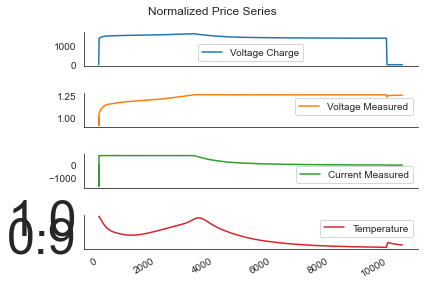

In [81]:
axes = df.div(df.iloc[0]).plot(subplots=True)
for ax in axes.flatten():
    ax.set_xlabel('')
    plt.yticks(fontsize = 50)

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
plt.savefig("fig56.pdf",bbox_inches="tight")

sns.despine();





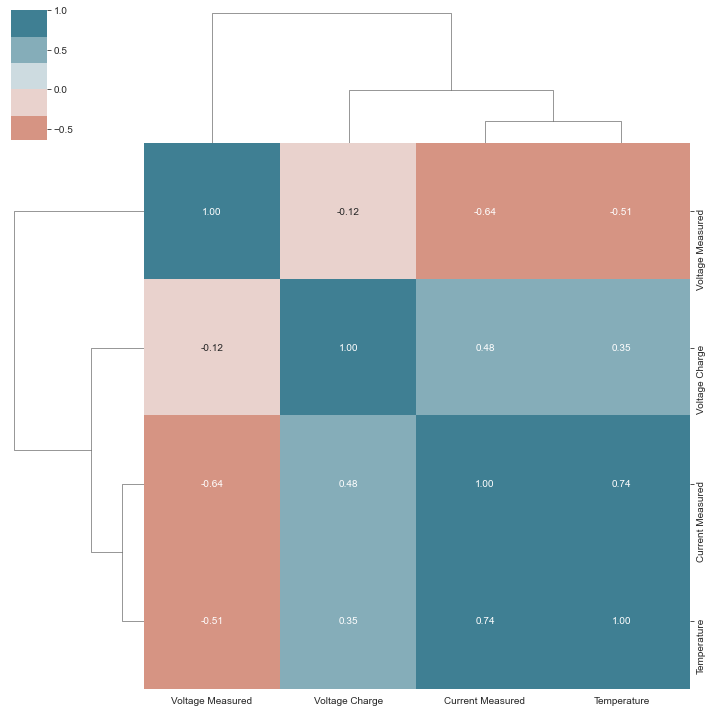

In [82]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

In [83]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [84]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)


In [85]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [86]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [87]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [88]:
#hidden_dim = 24_3
hidden_dim = 24
num_layers = 3

In [89]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [90]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [91]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [92]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [93]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [94]:
# train_steps = 100
# more train steps to get a better result
train_steps = 10000
gamma = 1

In [95]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [96]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [97]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            9960      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 4)             10900     
Total params: 20,860
Trainable params: 20,860
Non-trainable params: 0
_________________________________________________________________


In [98]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [99]:
import pydot

In [100]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [101]:
autoencoder_optimizer = Adam()

In [102]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [103]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:21<00:00, 31.11it/s]


In [104]:
# autoencoder.save(log_dir / 'autoencoder')

In [105]:
supervisor_optimizer = Adam()

In [106]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [107]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:46<00:00, 60.20it/s]


In [108]:
# supervisor.save(log_dir / 'supervisor')

In [109]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [110]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,585
Trainable params: 28,585
Non-trainable params: 0
_________________________________________________________________


In [111]:
plot_model(adversarial_supervised, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [112]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [113]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,785
Trainable params: 20,785
Non-trainable params: 0
_________________________________________________________________


In [114]:
plot_model(adversarial_emb, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [115]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [116]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 4)             10900     
Total params: 28,660
Trainable params: 28,660
Non-trainable params: 0
_________________________________________________________________


In [117]:
plot_model(synthetic_data, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [118]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [119]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [120]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            9960      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,785
Trainable params: 20,785
Non-trainable params: 0
_________________________________________________________________


In [121]:
plot_model(discriminator_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [122]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [123]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [124]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [125]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [126]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [127]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0865 | g_loss_u: 0.6959 | g_loss_s: 0.0009 | g_loss_v: 0.2432 | e_loss_t0: 0.0329
 1,000 | d_loss: 1.4122 | g_loss_u: 1.4833 | g_loss_s: 0.0000 | g_loss_v: 0.0595 | e_loss_t0: 0.0020
 2,000 | d_loss: 1.2843 | g_loss_u: 1.6570 | g_loss_s: 0.0001 | g_loss_v: 0.0357 | e_loss_t0: 0.0021
 3,000 | d_loss: 1.1952 | g_loss_u: 1.6313 | g_loss_s: 0.0000 | g_loss_v: 0.0353 | e_loss_t0: 0.0016
 4,000 | d_loss: 1.0749 | g_loss_u: 1.8133 | g_loss_s: 0.0000 | g_loss_v: 0.0465 | e_loss_t0: 0.0026
 5,000 | d_loss: 1.5577 | g_loss_u: 1.2724 | g_loss_s: 0.0001 | g_loss_v: 0.0393 | e_loss_t0: 0.0016
 6,000 | d_loss: 1.3249 | g_loss_u: 1.8100 | g_loss_s: 0.0001 | g_loss_v: 0.0687 | e_loss_t0: 0.0037
 7,000 | d_loss: 1.1464 | g_loss_u: 1.8166 | g_loss_s: 0.0000 | g_loss_v: 0.0352 | e_loss_t0: 0.0021
 8,000 | d_loss: 1.2701 | g_loss_u: 1.8709 | g_loss_s: 0.0001 | g_loss_v: 0.0253 | e_loss_t0: 0.0019
 9,000 | d_loss: 1.5325 | g_loss_u: 1.2657 | g_loss_s: 0.0000 | g_loss_v: 0.0202 | e_loss_t

In [128]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


In [129]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [130]:
len(generated_data)

7

In [131]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(896, 24, 4)

In [132]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [133]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(896, 24, 4)

In [134]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

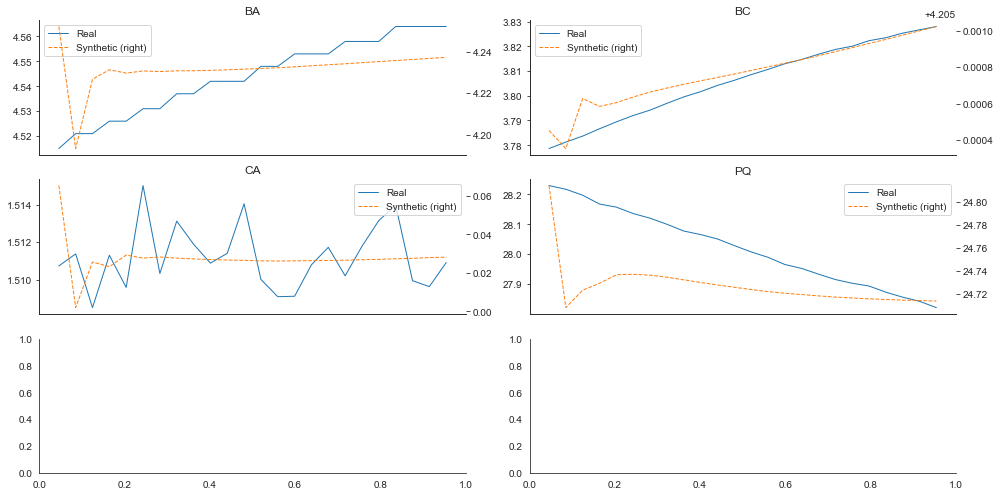

In [135]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})


     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()
fig.savefig("fig57.pdf",bbox_inches="tight")
     